# Rozpoznawanie emocji na podstawie twarzy człowieka

*Autorzy: Bartosz Belski & Aleksandra Duda*

### **Wprowadzenie**

Naszym celem jest stworzenie modelu, który na podstawie zdjęcia osoby będzie w stanie przypisać mu jedną z 7 emocji podstawowych zdefiniowanych przez Amerykańskiego Prof. psychologii Paula Ekmana(https://www.paulekman.com/universal-emotions/). 

### **Zbiór danych**

https://www.kaggle.com/deadskull7/fer2013

Zbiór danych fer2013.csv składa się z 3 kolumn:


*   Emotion    - kategoria emocji w zakresie <0;6>
*   Pixels     - zdjęcie o rozdzielczości 48x48 w postaci listy z liczbami reprezentującymi kolor piksela w skali szarości <0;255>
*   Usage      - Zastosowanie danego zdjęcia. [Więcej informacji](#usage)

Każdy z obrazów został już odpowiednio przetworzony tak, aby twarze zajmowała podobną przestrzeń oraz znajdowały się w centralnej części. 

Każdemu zdjęciu jest przypisana jedna z 7 podstawowych emocji:



## **Klasyfikacja & preprocessing**

### **Instalacja bibliotek**

In [1]:
!pip install mlxtend --upgrade --no-deps

### **Import bibliotek**

In [2]:
# biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import PIL

import mlxtend
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam

from platform import python_version

print(f"""
    PYTHON VERSION:      {python_version()}
    NUMPY VERSION:       {np.__version__}
    PANDAS VERSION:      {pd.__version__}
    TENSORFLOW VERSION:  {tf.__version__}
    KERAS VERSION:       {keras.__version__}
    MLEXTEND VERSION:    {mlxtend.__version__}
    PIL VERSION:         {PIL.__version__}
""")


    PYTHON VERSION:      3.9.12
    NUMPY VERSION:       1.22.3
    PANDAS VERSION:      1.4.4
    TENSORFLOW VERSION:  2.6.0
    KERAS VERSION:       2.6.0
    MLEXTEND VERSION:    0.21.0
    PIL VERSION:         9.2.0



### **Prezentacja surowych danych z *fer2013.csv***

In [3]:
data2d = pd.read_csv(f"data/fer2013/fer2013.csv", sep=",")

data2d.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


<a id='usage'></a>
### **Podział danych na 3 zbiory: uczące, publiczne, prywatne**

Zbiór danych został pobrany z https://www.kaggle.com, która organizuje konkursy dotyczące analizy danych.
Do czego służy dany zbiór:


*   Training     - dane do wytrenowania modelu (80% całości zbioru)
*   PublicTest   - dane publiczne do drabinki konkursowej (10% całości zbioru)
*   PrivateTest  - dane do weryfikacji ostatecznego wyniku konkursu (10% całości zbioru)



In [4]:
data2d.value_counts('Usage', normalize=True)

Usage
Training       0.799983
PrivateTest    0.100008
PublicTest     0.100008
dtype: float64

### **Kategorie emocji**

In [5]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

### **Dystrybucja cech w zbiorze**

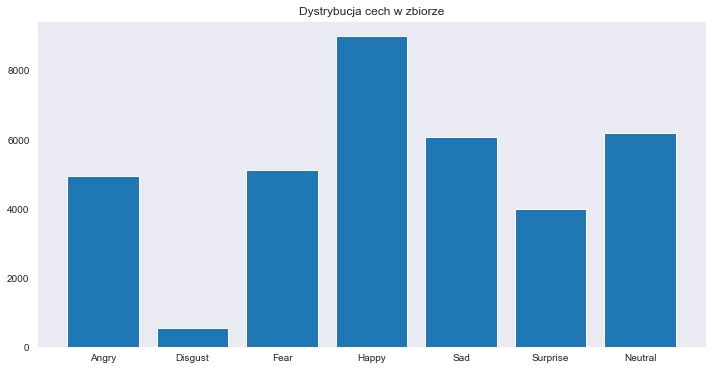

In [6]:
def plot_emotion_distributions(array1, title1=''):
    df_array1 = array1

    fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs.bar(x, y.sort_index())
    axs.set_title(title1)
    axs.grid()

    plt.show()

plot_emotion_distributions(data2d, "Dystrybucja cech w zbiorze")

### **Funkcje do obróbki danych**

In [7]:
def pre_process_image(pixel_map: np.ndarray, label_map: np.ndarray) -> tuple:
    images = pixel_map.reshape((pixel_map.shape[0], 48, 48, 1))
    images = images/255 # scale to [0,1]

    labels = to_categorical(label_map)

    return images, labels


def prepare_data(data: pd.DataFrame) -> tuple:
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label


def plot_emotion(emotion: int, samples: int = 7) -> None:
    fig, axs = plt.subplots(1, samples, figsize=(20, 20))
    fig.subplots_adjust(hspace=.5, wspace=.5)

    for i in range(samples):
        idx = data2d[data2d['emotion'] == emotion].index[i]
        axs[i].imshow(images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[labels[idx].argmax()])


### **Wizualizacja danych w postaci zdjęć z daną emocją**

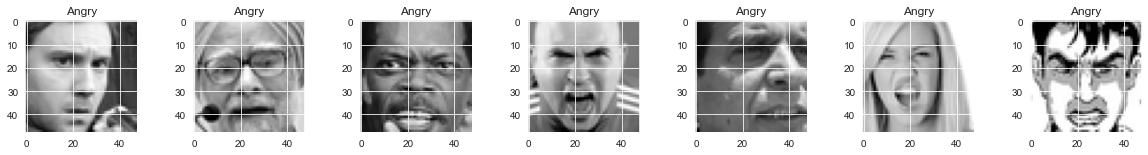

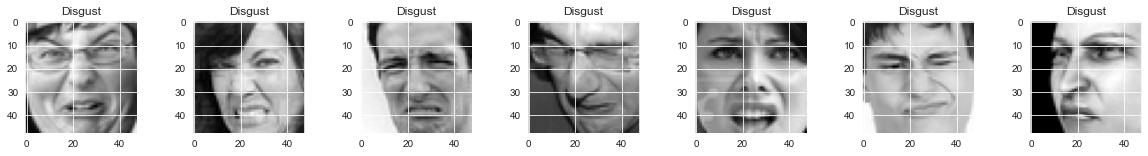

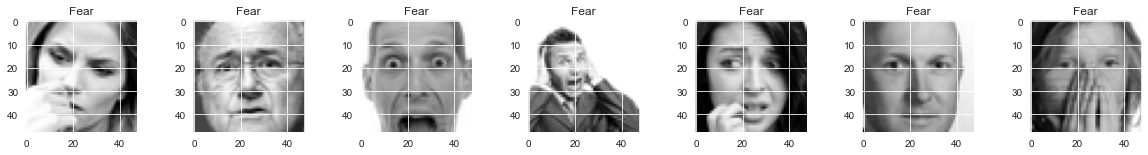

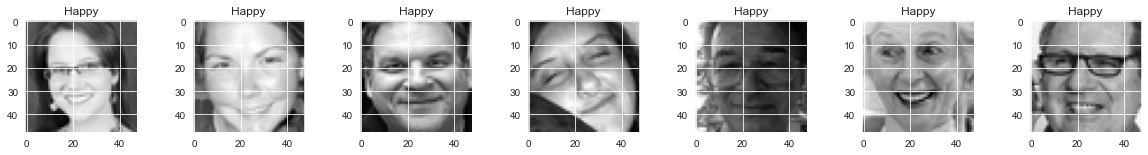

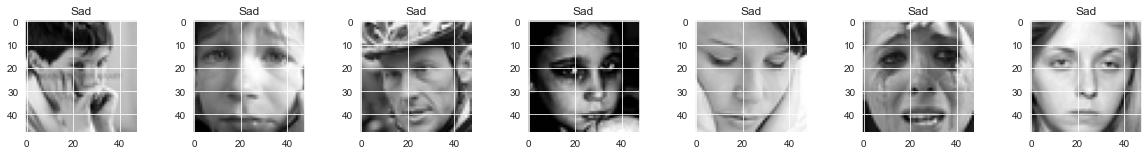

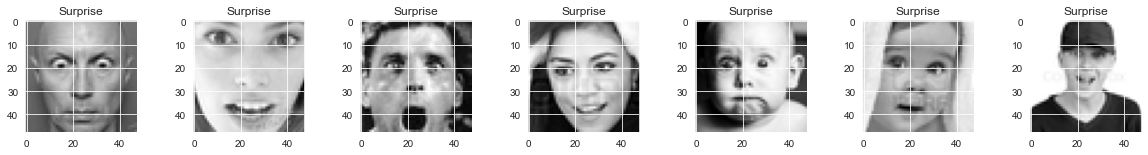

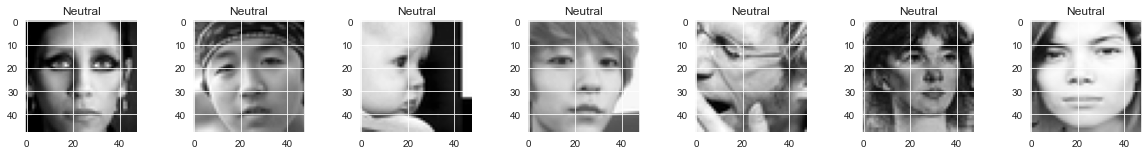

In [8]:
image_array, image_label = prepare_data(data2d)

images, labels = pre_process_image(image_array, image_label)

for emotion, _ in emotions.items():
    plot_emotion(emotion)

### **Utworzenie Datasetu Tensorflow**

In [9]:
ds = tf.data.Dataset.from_tensor_slices((images, labels))

### **Podział na zbiory trenujące i walidacyjne**

In [10]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_images, _, test_images = get_dataset_partitions_tf(ds, len(ds))

### **Data Augmentation**

In [11]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

### **Utworzenie batchy dla zbioru trenującego i walidacyjnego**

In [12]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [13]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

### **Model sieci CNN**

In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

### **Trenowanie modelu**

In [16]:
import math

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

STEPS_PER_EPOCH = compute_steps_per_epoch(len(train_images))
VALIDATION_STEPS = compute_steps_per_epoch(len(test_images))

In [17]:
EPOCHS = 20

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
449/449 [==============================] - 8s 11ms/step - loss: 1.6459 - accuracy: 0.3411 - val_loss: 1.4814 - val_accuracy: 0.4284
Epoch 2/20
449/449 [==============================] - 5s 10ms/step - loss: 1.4029 - accuracy: 0.4581 - val_loss: 1.3344 - val_accuracy: 0.4816
Epoch 3/20
449/449 [==============================] - 4s 10ms/step - loss: 1.2766 - accuracy: 0.5118 - val_loss: 1.1939 - val_accuracy: 0.5474
Epoch 4/20
449/449 [==============================] - 5s 11ms/step - loss: 1.1999 - accuracy: 0.5430 - val_loss: 1.1444 - val_accuracy: 0.5618
Epoch 5/20
449/449 [==============================] - 5s 11ms/step - loss: 1.1391 - accuracy: 0.5675 - val_loss: 1.1250 - val_accuracy: 0.5632
Epoch 6/20
449/449 [==============================] - 5s 11ms/step - loss: 1.0865 - accuracy: 0.5911 - val_loss: 1.0307 - val_accuracy: 0.6128
Epoch 7/20
449/449 [==============================] - 5s 11ms/step - loss: 1.0349 - accuracy: 0.6092 - val_loss: 1.0349 - val_accuracy: 0.6142

### **Testowanie modelu**

In [18]:
scores = model.evaluate(test_batches.take(-1), verbose=0)
print("Trafność modelu: %.2f%%" % (scores[1]*100))

pred_test_labels = model.predict(test_batches.take(-1))

Trafność modelu: 75.38%


### **Analiza procesu trenowania**

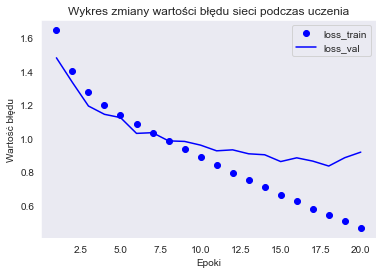

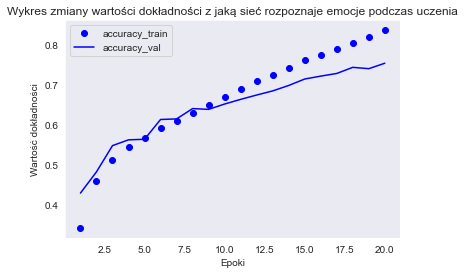

In [19]:
loss = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('Wykres zmiany wartości błędu sieci podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość błędu')
plt.legend()
plt.grid()
plt.show()

acc = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('Wykres zmiany wartości dokładności z jaką sieć rozpoznaje emocje podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość dokładności')
plt.legend()
plt.grid()
plt.show()

### **Macierz błędu**

C:\Users\Arkan\AppData\Local\Temp\ipykernel_12404\366035150.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


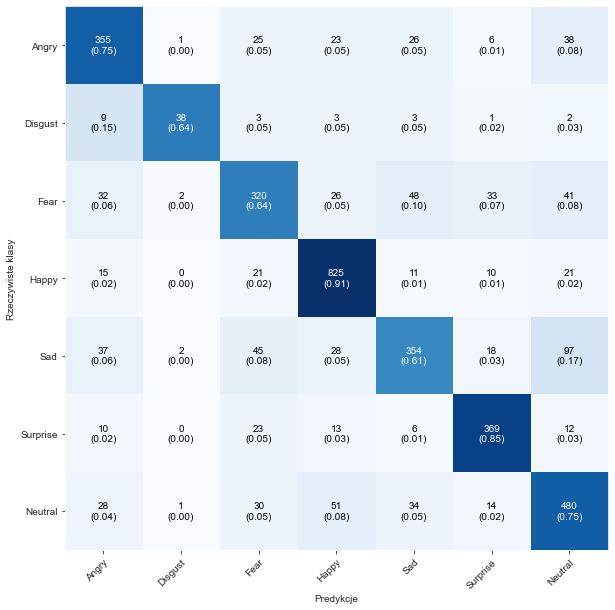

In [20]:
from mlxtend.plotting import plot_confusion_matrix

y_pred = []
y_true = []

for image_batch, label_batch in test_batches:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=-1))


true_categories = tf.argmax(tf.concat([item for item in y_true], axis=0), axis=1)
predicted_categories = tf.concat([item for item in y_pred], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)
fig, ax = mlxtend.plotting.plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                # show_absolute=True,
                                class_names=emotions.values(),
                                figsize=(10, 10))
ax.set_ylabel('Rzeczywiste klasy')
ax.set_xlabel('Predykcje')
fig.show()


## **Wariant dla wyliczonych wag klas**

### **Reset procesu uczenia**

In [21]:
keras.backend.clear_session()

### **Obliczanie wag klas**

In [22]:
class_weights = {}

(unique, counts) = np.unique(labels, return_counts=True, axis=0)
min_count = min(counts)
for distribution, u in zip(counts, unique):
    print(f"{emotions[u.tolist().index(1)]}:{distribution}")
    class_weights[u.tolist().index(1)] = distribution/min_count

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(labels, axis=1)
sklearn_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
sklearn_class_weights = dict(enumerate(sklearn_class_weights))

class_weights_mapped = {emotions[oldkey]: newkey for (oldkey, newkey) in class_weights.items()}
sklearn_class_weights_mapped = {emotions[oldkey]: newkey for (oldkey, newkey) in sklearn_class_weights.items()}

print(class_weights_mapped)
print(sklearn_class_weights_mapped)

Neutral:6198
Surprise:4002
Sad:6077
Happy:8989
Fear:5121
Disgust:547
Angry:4953
{'Neutral': 11.3308957952468, 'Surprise': 7.316270566727606, 'Sad': 11.109689213893967, 'Happy': 16.43327239488117, 'Fear': 9.361974405850091, 'Disgust': 1.0, 'Angry': 9.054844606946984}
{'Angry': 1.035072539009547, 'Disgust': 9.372420997649517, 'Fear': 1.001115853488437, 'Happy': 0.5703319930708962, 'Sad': 0.8436258492207152, 'Surprise': 1.2810380524023703, 'Neutral': 0.8271562255105334}


### **Trenowanie modelu**

In [23]:
EPOCHS = 20

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          class_weight=sklearn_class_weights,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
449/449 [==============================] - 5s 11ms/step - loss: 0.5597 - accuracy: 0.7989 - val_loss: 1.1510 - val_accuracy: 0.6663
Epoch 2/20
449/449 [==============================] - 5s 11ms/step - loss: 0.5201 - accuracy: 0.8085 - val_loss: 0.9247 - val_accuracy: 0.7343
Epoch 3/20
449/449 [==============================] - 5s 11ms/step - loss: 0.4319 - accuracy: 0.8366 - val_loss: 0.9967 - val_accuracy: 0.7181
Epoch 4/20
449/449 [==============================] - 5s 11ms/step - loss: 0.3835 - accuracy: 0.8560 - val_loss: 0.9833 - val_accuracy: 0.7376
Epoch 5/20
449/449 [==============================] - 5s 11ms/step - loss: 0.3634 - accuracy: 0.8628 - val_loss: 0.9212 - val_accuracy: 0.7643
Epoch 6/20
449/449 [==============================] - 5s 11ms/step - loss: 0.3433 - accuracy: 0.8701 - val_loss: 0.9780 - val_accuracy: 0.7563
Epoch 7/20
449/449 [==============================] - 5s 11ms/step - loss: 0.3153 - accuracy: 0.8794 - val_loss: 1.0289 - val_accuracy: 0.7655

### **Testowanie modelu**

In [24]:
scores = model.evaluate(test_batches.take(-1), verbose=0)
print("Trafność modelu: %.2f%%" % (scores[1]*100))

pred_test_labels = model.predict(test_batches.take(-1))

Trafność modelu: 79.08%


### **Analiza procesu trenowania**

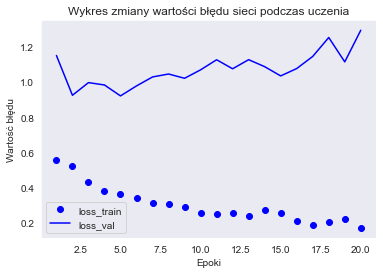

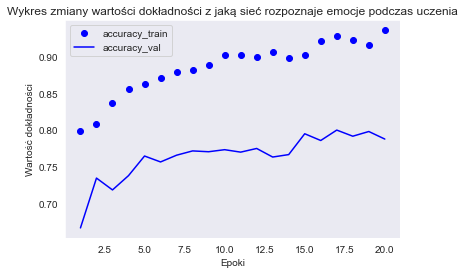

In [25]:
loss = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('Wykres zmiany wartości błędu sieci podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość błędu')
plt.legend()
plt.grid()
plt.show()

acc = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('Wykres zmiany wartości dokładności z jaką sieć rozpoznaje emocje podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość dokładności')
plt.legend()
plt.grid()
plt.show()

### **Macierz błędu**

C:\Users\Arkan\AppData\Local\Temp\ipykernel_12404\3819779646.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


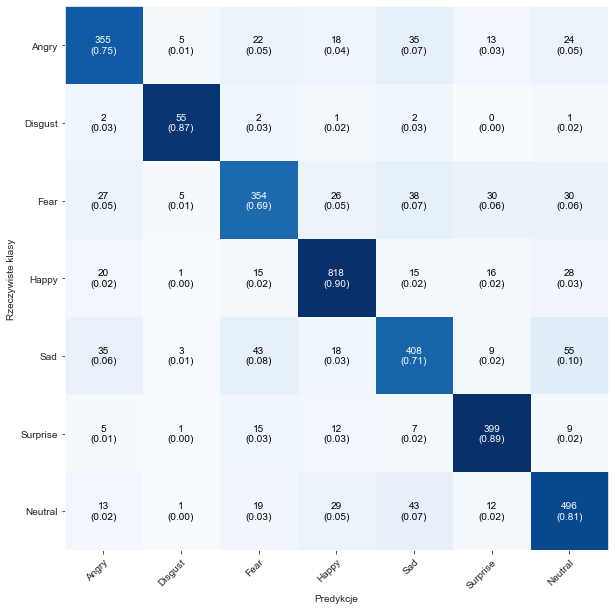

In [26]:
y_pred = []
y_true = []

for image_batch, label_batch in test_batches:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=-1))


true_categories = tf.argmax(tf.concat([item for item in y_true], axis=0), axis=1)
predicted_categories = tf.concat([item for item in y_pred], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)
fig, ax = mlxtend.plotting.plot_confusion_matrix(conf_mat=cm,
                                                 show_normed=True,
                                                 # show_absolute=True,
                                                 class_names=emotions.values(),
                                                 figsize=(10, 10))
ax.set_ylabel('Rzeczywiste klasy')
ax.set_xlabel('Predykcje')
fig.show()


## **Test na zdjęciu spoza zbioru danych**

In [30]:
from PIL import Image, ImageOps

og_image = Image.open(f"data/emotions/happy.jpg")
reshaped_image = og_image.resize((48, 48))

gray_image = ImageOps.grayscale(reshaped_image)

pixels = np.array(list(gray_image.getdata()))

custom_image = np.reshape(pixels, (48, 48, 1))
custom_image = custom_image/255 # scale to [0,1]
custom_image_array = np.ndarray((1, 48, 48, 1))
custom_image_array[0] = custom_image

predictions = model.predict(custom_image_array)

# predictions
emotions[predictions.argmax(axis=-1)[0]]

'Happy'

In [28]:
class_weights = {}

(unique, counts) = np.unique(labels, return_counts=True, axis=0)
min_count = min(counts)
for distribution, u in zip(counts, unique):
    print(f"{emotions[u.tolist().index(1)]}:{distribution}")
    class_weights[u.tolist().index(1)] = distribution/min_count

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(labels, axis=1)
sklearn_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
sklearn_class_weights = dict(enumerate(sklearn_class_weights))

class_weights_mapped = {emotions[oldkey]: newkey for (oldkey, newkey) in class_weights.items()}
sklearn_class_weights_mapped = {emotions[oldkey]: newkey for (oldkey, newkey) in sklearn_class_weights.items()}

print(class_weights_mapped)
print(sklearn_class_weights_mapped)

### **Trenowanie modelu**

In [29]:
EPOCHS = 20

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          class_weight=sklearn_class_weights,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

### **Testowanie modelu**

### **Analiza procesu trenowania**

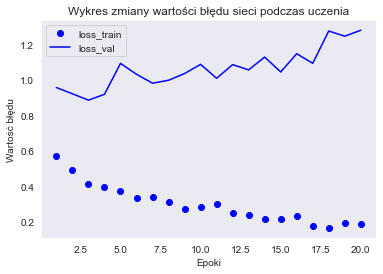

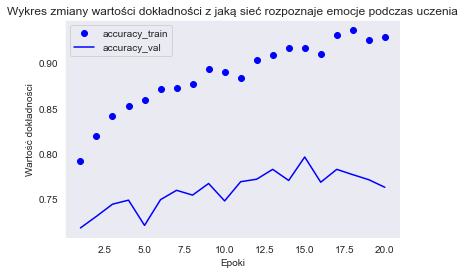

In [29]:
loss = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('Wykres zmiany wartości błędu sieci podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość błędu')
plt.legend()
plt.grid()
plt.show()

acc = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('Wykres zmiany wartości dokładności z jaką sieć rozpoznaje emocje podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Wartość dokładności')
plt.legend()
plt.grid()
plt.show()

### **Macierz błędu**

C:\Users\Arkan\AppData\Local\Temp\ipykernel_10904\3819779646.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


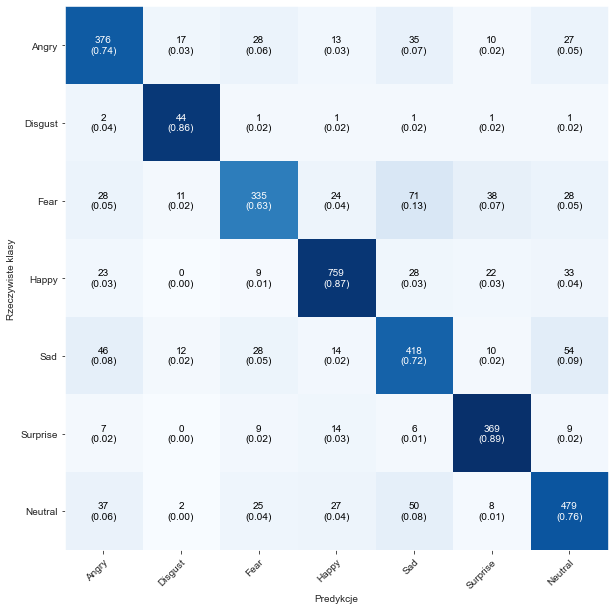

In [30]:
y_pred = []
y_true = []

for image_batch, label_batch in test_batches:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=-1))


true_categories = tf.argmax(tf.concat([item for item in y_true], axis=0), axis=1)
predicted_categories = tf.concat([item for item in y_pred], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)
fig, ax = mlxtend.plotting.plot_confusion_matrix(conf_mat=cm,
                                                 show_normed=True,
                                                 # show_absolute=True,
                                                 class_names=emotions.values(),
                                                 figsize=(10, 10))
ax.set_ylabel('Rzeczywiste klasy')
ax.set_xlabel('Predykcje')
fig.show()


## **Test na zdjęciu spoza zbioru danych**

In [33]:
from PIL import Image, ImageOps

og_image = Image.open(f"data/emotions/happy.jpg")
reshaped_image = og_image.resize((48, 48))

gray_image = ImageOps.grayscale(reshaped_image)

pixels = np.array(list(gray_image.getdata()))

custom_image = np.reshape(pixels, (48, 48, 1))
custom_image = custom_image/255 # scale to [0,1]
custom_image_array = np.ndarray((1, 48, 48, 1))
custom_image_array[0] = custom_image

predictions = model.predict(custom_image_array)

# predictions
emotions[predictions.argmax(axis=-1)[0]]


'Happy'

### **Oryginalne zdjęcie**

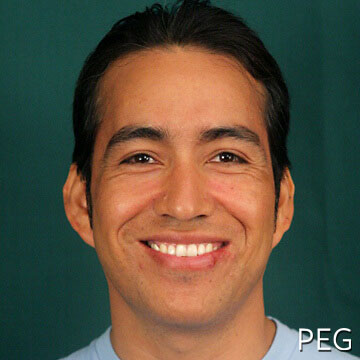

In [34]:
og_image

### **Zdjęcie po obróbce**

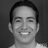

In [35]:
gray_image

### **Wnioski**

Podczas analizy wyników naszej sieci konwolucyjnej zrozumieliśmy, że ilość danych która została przygotowana jest niewystarczająca by uzyskać wynik, który by nas w pełni zadowolił. 

Wnioski z naszej sieci konwolucyjnej:


*   Udało nam się stworzyć prostą sieć, która jest w stanie uzyskać ~55% dokładności w rozpoznawaniu emocji.
*   Sieć uzyskuje taki wynik już po pierwszych kilku epokach
*   Sieć jest w stanie uzyskać wynik ~55% już po 20 minutach

Wnioski z wykresów:


*   Od około 6 epoki widzimy efekt "przeuczenia" naszej sieci
*   Optymalna ilość epok podczas nauczania to 6-8, dalsze epoki nie poprawiają jakości modelu.

Wnioski z macierzy błędu:

*   Model jest najpewniejszy podczas rozpozanawania **Happy**
*   Model najgorzej rozpoznawał **Disgust**(w połowie przypadków był mylony z **Angry**)
*   Model żadnego zdjęcia nie zakwalifikował jako **Disgust**(co jest wynikiem najmniejszej ilości zdjęć tego typu w naszym zbiorze danych)



